# Practice with first-order algorithms



Having established a general framework for implementing and testing learning algorithms in a <a href="FrameworkIntro.ipynb">previous section</a>, we develop the optimization part of this framework a bit further, implementing a class of first-order line search iterative update rules which are often useful in machine learning. The running assumption moving forward is that we have observations $z_{1},\ldots,z_{n}$, a loss function $L(w;z)$ depending on data $z$ and controllable parameter $w \in \mathbb{R}^d$, with gradient

\begin{align*}
\nabla L(w;z) = \left( \frac{\partial L(w;z)}{\partial w_{1}}, \ldots, \frac{\partial L(w;z)}{\partial w_{d}}\right)
\end{align*}

defined for all $z$. Furthermore, our learning strategy is empirical risk minimization (ERM):

\begin{align*}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum_{i=1}^{n} L(w;z_{i}) \to \widehat{w}.
\end{align*}

Note that the ERM solution $\widehat{w}$ here need not be unique, and depending on implementation method used, different ERM solutions may be achieved, with potentially dramatic differences in generalization ability.

__Contents:__

- <a href="#linesearch">Line search class</a>

- <a href="#GD">Gradient descent</a>

- <a href="#FDGD">Finite-difference GD</a>

- <a href="#SGD">Stochastic GD</a>

- <a href="#testing">More detailed algorithm testing</a>

___

<a id="linesearch"></a>
## Line search class

To get started, let us define a base class for *line search* algorithms. This family of algorithms is very straightforward: given an initial value $w_{(0)}$, for each step $t$ we compute

\begin{align*}
w_{(t+1)} \gets w_{(t)} + \alpha_{(t)} u_{(t)}
\end{align*}

with sub-routines executed as $w_{(t)} \mapsto u_{(t)} \mapsto \alpha_{(t)}$. That is, we compute the *search direction* $u_{(t)}$ before computing the step size $\alpha_{(t)} > 0$. Let's prepare a general-purpose class `Algo_LineSearch` as below.

In [1]:
class Algo_LineSearch:
    '''
    Basic archetype of an iterator for implementing a line
    search algorithm.

    Note that we assume w_init is a nparray matrix with the
    shape (d,1), where d represents the number of total
    parameters to be determined.
    '''

    def __init__(self, w_init, step, t_max, thres,
                 verbose=False, store=False):

        # Attributes passed from user.
        self.w = w_init
        self.step = step
        self.t_max = t_max
        self.thres = thres
        self.verbose = verbose
        self.store = store

        # Attributes determined internally.
        if self.w is None:
            self.nparas = None
            self.w_old = None
        else:
            self.nparas = self.w.size
            self.w_old = np.copy(self.w)
        self.t = None
        self.diff = np.inf
        self.stepcost = 0 # for per-step costs.
        self.cumcost = 0 # for cumulative costs.

        # Keep record of all updates (optional).
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=self.w.dtype)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        
        
    def __iter__(self):

        self.t = 0

        if self.verbose:
            print("(via __iter__)")
            self.print_state()
            
        return self
    

    def __next__(self):
        '''
        Check the stopping condition(s).
        '''
        
        if self.t >= self.t_max:
            raise StopIteration

        if self.diff <= self.thres:
            raise StopIteration

        if self.verbose:
            print("(via __next__)")
            self.print_state()
            
            
    def update(self, model, data):
        '''
        Carry out the main parameter update.
        '''
        
        # Parameter update.
        newdir = self.newdir(model=model, data=data)
        stepsize = self.step(t=self.t, model=model, data=data, newdir=newdir)
        self.w = self.w + stepsize * np.transpose(newdir)

        # Update the monitor attributes.
        self.monitor_update(model=model, data=data)

        # Run cost updates.
        self.cost_update(model=model, data=data)

        # Keep record of all updates (optional).
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


    def newdir(self, model, data):
        '''
        By default returns None. This will be
        implemented by sub-classes that inherit
        this class.
        '''
        return None
    

    def monitor_update(self, model, data):
        '''
        By default returns None. This will be
        implemented by sub-classes that inherit
        this class.
        '''
        return None

    
    def cost_update(self, model, data):
        '''
        By default returns None. This will be
        implemented by sub-classes that inherit
        this class.
        '''
        return None

    
    def print_state(self):
        print("t =", self.t, "( max =", self.t_max, ")")
        print("diff =", self.diff, "( thres =", self.thres, ")")
        if self.verbose:
            print("w = ", self.w)
        print("------------")


In its present state, this is just a base class and is of no use on its own.In the following sub-sections, we shall implement various sub-classes which fill in the details. Just for reference, the key elements are as follows.

- `update()` contains all iterative updates.
- `monitor_update()` does updates related to stopping conditions.
- `cost_update()` does updates related to computational cost.
- Stopping conditions: controlled by `thres` and `t_max`.
- Parameter updates go in the order of calling `newdir()`, upon which we base the new step size, computed by `step()`. With these computed, the line search update is carried out.




In [2]:
import numpy as np
import math

import models
import dataclass
import helpers as hlp

In [3]:
# Prepare the risk function and some data to test the various
# algorithms to follow in a simple 2D setting.

# Data-related parameters.
n = 15
d = 2
epsilon_sd = 2.0
X_sd = 1.0
X_cov = X_sd * np.eye(d)
w_star = math.pi * np.ones((d,1), dtype=np.float32)

# Put together risk function.
def risk(w):
    return hlp.riskMaker(w=w, A=X_cov, b=epsilon_sd, w_star=w_star)

# Generate data.
data = dataclass.DataSet()
X = np.random.normal(loc=0.0, scale=X_sd, size=(n,d))
epsilon = np.random.normal(loc=0.0, scale=epsilon_sd, size=(n,1))
y = X.dot(w_star) + epsilon
data.init_tr(X=X, y=y) # all for training

<a id="GD"></a>
## Gradient descent

When trying to determine the search direction, most methods are designed to ensure that the search direction is a "descent direction". Consider the one-dimensional case, say $f:\mathbb{R} \to \mathbb{R}$. In this case, the search direction is simply "left" or "right", namely $u_{(t)} \in \{-1,1\}$.

- If $f^{\prime}(w_{(t)}) > 0$, then the function is increasing, and thus we know that if we go left, i.e., set $u_{(t)} = -1$, with the right step size it is possible to make the objective decrease.

- If $f^{\prime}(w_{(t)}) < 0$, then the function is decreasing, by the same logic we should go right, i.e., $u_{(t)} = -1$.

In both cases, note that $u_{(t)} \, f^{\prime}(w_{(t)}) < 0$ holds. 

This property generalizes to the multi-variate case of say $f: \mathbb{R}^d \to \mathbb{R}$, where $\langle u_{(t)}, \nabla f(w_{(t)}) \rangle < 0$ guarantees that $u_{(t)}$ is a descent direction. Geometrically, this means that the update direction should form an *acute* angle with the negative gradient $(-1)\,f^{\prime}(w_{(t)})$.

Gradient descent is simply the special case in which the angle between the search direction and the negative gradient is zero. This is called "steepest descent" in the Euclidean norm. To see this, recall that "steepness" in a particular direction is quantified using the directional derivative. In our case of interest, via the chain rule we have

\begin{align*}
\frac{\partial f(w_{(t)}+\alpha u)}{\partial \alpha} & = \sum_{j=1}^{d} \left( \left.\frac{\partial f(x)}{\partial x_{j}}\right|_{x=w_{(t)}+\alpha u} \right) \frac{\partial(w_{(t),j}+\alpha u_{j})}{\partial \alpha}, \text{ set } \alpha = 0\\
& = \langle u, \nabla f(w_{(t)}) \rangle
\end{align*}

where the inner product is the usual dot product. Steepest descent requires that this value be minimized. Equivalently, multiply it by $(-1)$ and consider an upper bound via Cauchy-Schwarz inequality,

\begin{align*}
\langle u, (-1)\nabla f(w_{(t)}) \rangle \leq \|u\| \|\nabla f(w_{(t)})\|.
\end{align*}

Consider all $u$ on the unit circle ($\|u\|=1$), note that

\begin{align*}
\left\langle \frac{(-1)\nabla f(w_{(t)})}{\|\nabla f(w_{(t)})\|}, (-1)\nabla f(w_{(t)}) \right\rangle = \|\nabla f(w_{(t)})\|.
\end{align*}

That is, setting $u$ to the negative gradient direction achieves this upper bound, which equivalently means that it minimizes $\langle u, \nabla f(w_{(t)}) \rangle$ among all possible directions.

With this background in place, actually implementing gradient descent is extremely straightforward. The update is as follows,

\begin{align*}
w_{(t+1)} = w_{(t)} - \frac{\alpha_{(t)}}{n} \sum_{i=1}^{n} \nabla L(w_{(t)};z_{i}).
\end{align*}

We introduce `Algo_GD` as a sub-class of `Algo_LineSearch`.

In [4]:
class Algo_GD(Algo_LineSearch):
    '''
    Iterator which implements a line-search steepest descent method,
    where the direction of steepest descent is measured using the
    Euclidean norm (this is the "usual" gradient descent). Here the
    gradient is a sample mean estimate of the true risk gradient.
    That is, this is ERM-GD.
    '''

    def __init__(self, w_init, step, t_max, thres, store):

        super(Algo_GD, self).__init__(w_init=w_init,
                                      step=step,
                                      t_max=t_max,
                                      thres=thres,
                                      store=store)

    def newdir(self, model, data):
        '''
        Determine the direction of the update.
        '''
        return (-1) * np.mean(model.g_tr(w=self.w, data=data),
                              axis=0, keepdims=True)

    def monitor_update(self, model, data):
        '''
        Update the counters and convergence
        monitors used by the algorithm. This is
        executed once every step.

        For GD, increment counter and check the
        differences at each step.
        '''
        self.t += 1
        self.diff = np.linalg.norm((self.w-self.w_old))
        self.w_old = np.copy(self.w)

        
    def cost_update(self, model, data):
        '''
        Update the amount of computational resources
        used by the routine.

        Cost here is number of gradient vectors
        computed. GD computes one vector for each
        element in the sample.
        '''
        self.stepcost = data.n_tr
        self.cumcost += self.stepcost


A few points:

- `newdir` implements the update assuming that the objective function is the sample mean of $n$ losses, thus we take `np.mean()` over `axis=0`, namely average all the rows.
- `monitor_update` checks the per-step difference and increments the step count `t`.
- `cost_update` counts the number of gradients computed at each step.

In [5]:
# Initialize model.
mod = models.LinearL2()

# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_GD(w_init=w_init,
             step=make_step(0.25),
             t_max=15,
             thres=1e-03,
             store=True)

In [6]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

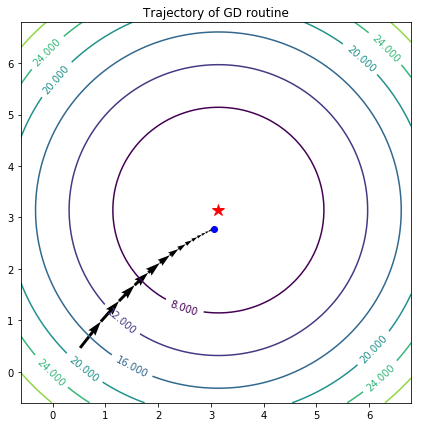

In [8]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

def risk2D_helper(w1, w2):
    w2D = np.array([w1,w2]).reshape((2,1))
    return risk(w=w2D)

risk2D = np.vectorize(risk2D_helper)

if (d == 2):

    tmpdel = np.linalg.norm(w_star-w_init) * 1
    xvals = np.arange(w_star[0]-tmpdel,w_star[0]+tmpdel, 0.1)
    yvals = np.arange(w_star[1]-tmpdel,w_star[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = risk2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*w_star, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of GD routine')
    plt.show()
    


__Exercises:__

0. Investigate how modifying the underlying data distribution, sample size, and dimension impacts the error trajectory. Describe what you observe.

0. Analogously, modify the algorithm settings under fixed data settings. Describe how algorithm behavior and "optimal" settings depend on the underlying distribution.

<a id="FDGD"></a>
## More examples: finite-difference GD

With some basic ideas covered, we can proceed with some modifications of the gradient descent procedure to study new learning algorithms. A full-fledged implementation of GD requires access to the gradient. In the least-squares model considered earlier, we had such access, but there are situations in which the gradient itself it not directly computable, even if the loss itself is (e.g., cases where the loss itself is defined implicitly).

In such settings, assuming the loss is sufficiently smooth, we can easily approximate the gradient using finite-difference methods, well-known since at least the time of Euler. Applying a perturbation to one coordinate at a time,

\begin{align*}
\Delta_{j} & = (0,\ldots,\delta,\ldots,0), \text{ such that} \\
w + \Delta_{j} & = (w_{1},\ldots,(w_{j}+\delta),\ldots,w_{d}), \quad j = 1,\ldots,d 
\end{align*}

we can take finite differences to approximate the partial derivatives of interest, 

\begin{align*}
\widehat{g}_{i,j}(w) & = \frac{L((w+\Delta_{j});z_{i})-L(w;z_{i})}{\delta} \approx \frac{\partial L(w;z_{i})}{\partial w_{j}}, \quad i=1,\ldots,n \\
\widehat{g}_{i}(w) & = \left(\widehat{g}_{i,1}(w),\ldots,\widehat{g}_{i,d}(w)\right), \quad i=1,\ldots,n.
\end{align*}

The procedure implemented here simply replaces the true gradients with their finite-difference approximations, evaluated at each point, namely we update using

\begin{align*}
w_{(t+1)} = w_{(t)} - \alpha_{(t)} \frac{1}{n}\sum_{i=1}^{n} \widehat{g}_{i}(w_{(t)}).
\end{align*}

The implementation is straightforward, as below.

In [9]:
class Algo_FDGD(Algo_LineSearch):
    '''
    Finite-difference gradient descent.
    '''

    def __init__(self, w_init, step, delta, t_max, thres, store):

        super(Algo_FDGD, self).__init__(w_init=w_init,
                                        step=step,
                                        t_max=t_max,
                                        thres=thres,
                                        store=store)
        self.delta = delta
        self.delmtx = np.eye(self.w.size) * delta
        
    
    def newdir(self, model, data):
        '''
        Determine the direction of the update.
        '''
        out = np.zeros((1,self.w.size), dtype=self.w.dtype)
        loss = model.l_tr(w=self.w, data=data)
        
        # Perturb one coordinate at a time, then 
        # compute finite difference.
        for j in range(self.w.size):
            delj = np.take(self.delmtx,[j],axis=1)
            loss_delta = model.l_tr((self.w + delj), data=data)
            out[:,j] = np.mean(loss_delta-loss) / self.delta
            
        return out * (-1)
    

    def monitor_update(self, model, data):
        self.t += 1
        self.diff = np.linalg.norm((self.w-self.w_old))
        self.w_old = np.copy(self.w)
        
        
    def cost_update(self, model, data):
        self.stepcost = data.n_tr
        self.cumcost += self.stepcost


We can do perfectly analogous tests as in the previous set of experiments, with the only addition being that we must provide a `delta` parameter, namely the size of perturbation $\delta$ above.

In [10]:
# Initialize model.
mod = models.LinearL2()

# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_FDGD(w_init=w_init,
               step=make_step(0.15),
               delta=0.05,
               t_max=15,
               thres=1e-03,
               store=True)

In [11]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

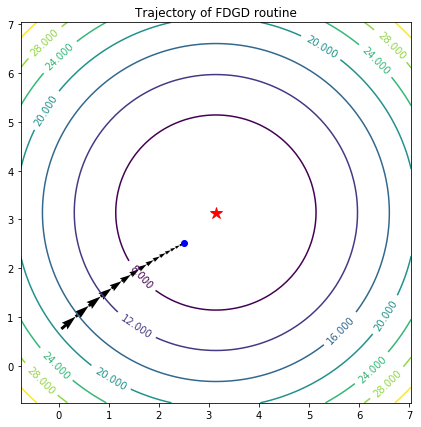

In [12]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

def risk2D_helper(w1, w2):
    w2D = np.array([w1,w2]).reshape((2,1))
    return risk(w=w2D)

risk2D = np.vectorize(risk2D_helper)

if (d == 2):

    tmpdel = np.linalg.norm(w_star-w_init) * 1
    xvals = np.arange(w_star[0]-tmpdel,w_star[0]+tmpdel, 0.1)
    yvals = np.arange(w_star[1]-tmpdel,w_star[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = risk2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*w_star, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of FDGD routine')
    plt.show()
    


As some extra practice, the above algorithm implements the *forward difference* approximation of $\nabla L(w;z)$, but this is by no means the only approximation, nor is it the best.

For example, we have

\begin{align*}
\frac{l(w;z_{i})-l(w-\Delta_{j} ;z_{i})}{\delta} \quad \text{and} \quad \frac{l(w+\Delta_{j};z_{i})-l(w-\Delta_{j};z_{i})}{2\delta}
\end{align*}

respectively known as the *backward difference* and *central difference* approximations of the $j$th partial derivative. The central difference approximation is typically a much better choice than either of the forward/backward versions.

__Exercises:__

0. Modify `Algo_FDGD` or create a new class to implement these two approaches. How do they compare with the original in terms of their trajectory? Their rate of convergence? Their robustness as $n$ becomes small?

<a id="SGD"></a>
## Stochastic GD

When we have many controllable parameters $w=(w_{1},\ldots,w_{d})$, that means that we must compute many partial derivatives in order to acquire the gradient of the loss evaluated at any given point. When we have $n$ observations and large $d$, this can be computationally prohibitive in an iterative scheme such as the one explored above.

One way around this is to take a random sub-sample of the data, often called a *mini-batch*, and to run standard gradient descent on this smaller set. That is, we randomly choose indices

\begin{align*}
\mathcal{I} \subset \{1,2,\ldots,n\}
\end{align*}

with size $B = |\mathcal{I}| \ll n$. We then compute the mini-batch gradient

\begin{align*}
w_{(t+1)} = w_{(t)} - \frac{\alpha_{(t)}}{B}\sum_{i \in \mathcal{I}} \nabla L(w_{(t)};z_{i}).
\end{align*}

The classical case is where $B=1$, and is typically considered the canonical form of *stochastic gradient descent* (SGD). More generally, say each $i \in \mathcal{I}$ is sampled independently and uniformly from $\{1,\ldots,n\}$, then taking expectation with respect to these random indices, for any $w$,

\begin{align*}
\mathbf{E} \left( \frac{1}{B}\sum_{i \in \mathcal{I}} \nabla L(w;z_{i}) \right) & = \frac{1}{B}\sum_{i \in \mathcal{I}} \mathbf{E} \nabla L(w;z_{i})\\
 & = \frac{1}{B}\sum_{i \in \mathcal{I}}\left(\frac{1}{n} \sum_{j=1}^{n} \nabla L(w;z_{j}) \right)\\
 & = \frac{1}{n} \sum_{j=1}^{n} \nabla L(w;z_{j}).
\end{align*}

That is, the expected value of this random quantity is the "full gradient" itself. The hope is that after a sufficient number of inexpensive iterations, this variance will iron itself out. Let's implement this it to see how the algorithm behaves first-hand. A few modifications to `Algo_GD` yield `Algo_SGD` below.

In [13]:

class Algo_SGD(Algo_LineSearch):
    '''
    Stochastic companion to Algo_GD, where we randomly take
    sub-samples (called mini-batches) to compute the sample
    mean estimate of the underlying risk gradient. By using
    small mini-batches, the computational burden of each
    iteration is eased, at the cost of poorer statistical
    estimates.
    '''
    def __init__(self, w_init, step, batchsize, replace,
                 t_max, thres, store):

        super(Algo_SGD, self).__init__(w_init=w_init,
                                       step=step,
                                       t_max=t_max,
                                       thres=thres,
                                       store=store)
        self.batchsize = batchsize
        self.replace = replace

        # Computed internally.
        self.nseen = 0
        self.npasses = 0


    def newdir(self, model, data):
        '''
        Determine the direction of the update.
        '''
        shufidx = np.random.choice(data.n_tr,
                                   size=self.batchsize,
                                   replace=self.replace)
        return (-1) * np.mean(model.g_tr(w=self.w, data=data, n_idx=shufidx),
                              axis=0, keepdims=True)

    def monitor_update(self, model, data):
        '''
        Update the counters and convergence
        monitors used by the algorithm. This is
        executed once every step.
        '''
        self.t += 1
        self.nseen += self.batchsize
        if self.nseen >= data.n_tr:
            self.npasses += 1
            self.diff = np.linalg.norm((self.w-self.w_old))
            self.w_old = np.copy(self.w)
            self.nseen = self.nseen % data.n_tr
    
    def cost_update(self, model, data):
        '''
        Update the amount of computational resources
        used by the routine.

        Cost here is number of gradient vectors
        computed. SGD computes one for each element
        of the mini-batch used.
        '''
        self.stepcost = self.batchsize
        self.cumcost += self.stepcost


Just a few basic points.

- `batchsize` is $B$ above, controlling the size of the random subset to use. If $B=n$, then performs identically with `Algo_GD`.
- `replace` is a boolean controlling whether or not sub-sampling is done with replacement.
- `nseen` and `npasses` are used to monitor how many passes have been made over the whole data set, often called "epochs". For now termination rules are the same as GD.

In [14]:
# Initialize model.
mod = models.LinearL2()

# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))

def alpha_fixed(t, val):
    return val

def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_SGD(w_init=w_init,
              batchsize=1,
              replace=False,
              step=make_step(0.05),
              t_max=150,
              thres=-1.0, # nullifies this condition.
              store=True)

In [15]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

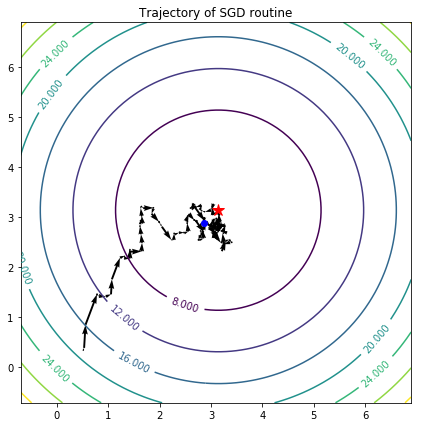

In [16]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

def risk2D_helper(w1, w2):
    w2D = np.array([w1,w2]).reshape((2,1))
    return risk(w=w2D)

risk2D = np.vectorize(risk2D_helper)

if (d == 2):

    tmpdel = np.linalg.norm(w_star-w_init) * 1
    xvals = np.arange(w_star[0]-tmpdel,w_star[0]+tmpdel, 0.1)
    yvals = np.arange(w_star[1]-tmpdel,w_star[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = risk2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*w_star, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of SGD routine')
    plt.show()
    


__Exercises:__

0. Repeat the exercises done above for GD; how do successful SGD settings differ from successful GD settings?

<a id="testing"></a>
## More detailed algorithm testing

In this section, we explore the behaviour of the different algorithms considered above as a function of time, averaged over many independent trials.

In [17]:
## Import all necessary modules.

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import models
import dataclass
import helpers as hlp

In [18]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
# NOTE: Initial weights are randomly generated in advance, 
# so that per-trial randomness here is only due to the data.

# Algorithm-related.
m_idx_todo = [0,1,2] # let's us manually pick and choose which methods to evaluate.
t_max = 30 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep

# Clerical.
mth_names = ["gd", "fdgd", "sgd"]
num_mths = len(mth_names)
mth_colours = ["black", "purple", "red"]

In [19]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [20]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centred* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Initialize models.
    mod = models.LinearL2(data=data)
    loss_star = np.mean(mod.l_tr(w=w_star, data=data))
    
    
    # Initialize all algorithms.
    al_gd = Algo_GD(w_init=w_init,
                    step=make_step(0.25),
                    t_max=t_max,
                    thres=thres,
                    store=True)
    al_fdgd = Algo_FDGD(w_init=w_init,
                        step=make_step(0.25),
                        delta=0.15,
                        t_max=t_max,
                        thres=thres,
                        store=True)
    al_sgd = Algo_SGD(w_init=w_init,
                      batchsize=1,
                      replace=False,
                      step=make_step(0.01),
                      t_max=t_max,
                      thres=thres,
                      store=True)
    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for mystep in al_gd:
            al_gd.update(model=mod, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod.l_tr(w=al_gd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_gd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_gd.w)-0
            idx += 1
        
    ## FD-GD.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        for mystep in al_fdgd:
            al_fdgd.update(model=mod, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod.l_tr(w=al_fdgd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_fdgd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_fdgd.w)-0
            idx += 1
        
    ## SGD.
    mthidx = 2
    if mthidx in m_idx_todo:
        idx = 0
        for mystep in al_sgd:
            al_sgd.update(model=mod, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod.l_tr(w=al_sgd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_sgd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_sgd.w)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

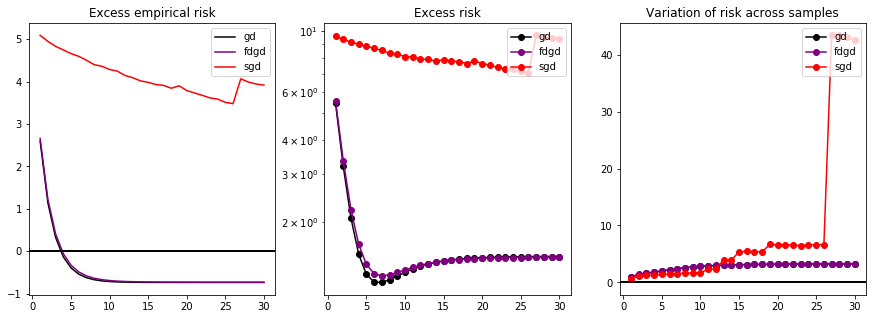

In [21]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")
    

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

__Exercises:__ 

0. Investigate how the data dimension, distribution, and algorithm settings impact *learning efficiency*, namely the ability to get to a better solution (in terms of true risk). Which settings tend to overfit? Which settings are "unstable" in the sense of having high variance over random draw of the sample?

0. Numpy has lots of probability distributions: modify the `hlp.noise_data` function (in `helpers_datagen` source file) to cover more data distributions, and investigate how algorithm performance changes.

___